<b> <font size="6"> PA006: Credit Card Dataset for Clustering </font></b>

# Imports

In [1]:
import pandas as pd
import numpy as np
import inflection
from IPython.core.display  import HTML
from sklearn import metrics as mt
from sklearn import preprocessing as pp

# EDA
from pandas_profiling import ProfileReport
import sweetviz as sv

# visualization
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

# Models
from sklearn import ensemble as en
from sklearn import cluster as cl
from sklearn import mixture as mx
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import ExtraTreesClassifier

# Reducers
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA as kpca
from sklearn               import manifold as mn
import umap.umap_ as umap

# Silhouette Visualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

from sklearn.preprocessing import normalize

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.rcParams['font.size'] = 25
    
    display(HTML( '<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
            
    sns.set()
    
jupyter_settings ()

Populating the interactive namespace from numpy and matplotlib


## Loading data

In [3]:
df_raw = pd.read_csv('C:/Users/DML1WFE/repos/projects/pa006_bank_marketing_strategy/bank_marketing_stretegy/data/raw/CCGENERAL.csv')

# Data Description

In [4]:
df01 = df_raw.copy()

## Columns Rename

In [5]:
old_cols = ['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
            'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
            'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
            'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
            'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
            'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, old_cols))

#rename
df01.columns = cols_new

## Data Dimensions

In [6]:
print ('Number of rows: {}'.format(df01.shape[0]))
print ('Number os columns:{}'.format(df01.shape[1]))

Number of rows: 8950
Number os columns:18


## Data Types

In [7]:
df01.dtypes

cust_id                              object
balance                             float64
balance_frequency                   float64
purchases                           float64
oneoff_purchases                    float64
installments_purchases              float64
cash_advance                        float64
purchases_frequency                 float64
oneoff_purchases_frequency          float64
purchases_installments_frequency    float64
cash_advance_frequency              float64
cash_advance_trx                      int64
purchases_trx                         int64
credit_limit                        float64
payments                            float64
minimum_payments                    float64
prc_full_payment                    float64
tenure                                int64
dtype: object

## Check Missing Values

In [8]:
df01.isna().sum() / df01.shape[0] * 100

cust_id                             0.000000
balance                             0.000000
balance_frequency                   0.000000
purchases                           0.000000
oneoff_purchases                    0.000000
installments_purchases              0.000000
cash_advance                        0.000000
purchases_frequency                 0.000000
oneoff_purchases_frequency          0.000000
purchases_installments_frequency    0.000000
cash_advance_frequency              0.000000
cash_advance_trx                    0.000000
purchases_trx                       0.000000
credit_limit                        0.011173
payments                            0.000000
minimum_payments                    3.497207
prc_full_payment                    0.000000
tenure                              0.000000
dtype: float64

## Replace Missing Values

In [9]:
df01['minimum_payments'] = df01['minimum_payments'].fillna(0)
df01['credit_limit'] = df01['credit_limit'].fillna(mean)

In [10]:
df01.isna().sum()

cust_id                             0
balance                             0
balance_frequency                   0
purchases                           0
oneoff_purchases                    0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
oneoff_purchases_frequency          0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

## Descriptive Statistics

In [11]:
num_attributes = df01.select_dtypes(include = ['float64', 'int64'])
cat_attributes = df01.select_dtypes(exclude = ['float64', 'int64', 'datetime64[ns]'])

### Numerical Attributes

In [12]:
# estimadores de localicação
est1 = pd.DataFrame(num_attributes.apply(np.mean)).T
est2 = pd.DataFrame(num_attributes.apply(np.median)).T
est3 = pd.DataFrame(num_attributes.apply(np.min)).T
est4 = pd.DataFrame(num_attributes.apply(np.max)).T

# estimadores de variabilidade
est5 = pd.DataFrame(num_attributes.apply(np.std)).T
est6 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min())).T

# skewness and kurtosis
est7 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
est8 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis())).T

# conatenate
m1 = pd.concat([est3, est4, est6, est1, est2, est5, est7, est8]).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std deviation', 'skewness', 'kurtosis']
m1

# percentis
quartis = num_attributes.apply( lambda x: np.quantile( x, q=[0.10, 0.25, 0.50, 0.75, 0.95, 0.99])).T.reset_index()
quartis.columns = ['attributes', 'P10', 'P25', 'P50', 'P75', 'P95', 'P99']

#
m2 = pd.merge(m1, quartis, how='inner', on='attributes')
m2

,attributes,min,max,range,mean,median,std deviation,skewness,kurtosis,P10,P25,P50,P75,P95,P99
0,balance,0.0,19043.13856,19043.13856,1564.474828,873.385231,2081.415590,2.393386,7.674751,23.575529,128.281915,873.385231,2054.140036,5909.111808,9338.804814
1,balance_frequency,0.0,1.00000,1.00000,0.877271,1.000000,0.236891,-2.023266,3.092370,0.454545,0.888889,1.000000,1.000000,1.000000,1.000000
2,purchases,0.0,49039.57000,49039.57000,1003.204834,361.280000,2136.515413,8.144269,111.388771,0.000000,39.635000,361.280000,1110.130000,3998.619500,8977.290000
3,oneoff_purchases,0.0,40761.25000,40761.25000,592.437371,38.000000,1659.795184,10.045083,164.187572,0.000000,0.000000,38.000000,577.405000,2671.094000,6689.898200
4,installments_purchases,0.0,22500.00000,22500.00000,411.067645,89.000000,904.287592,7.299120,96.575178,0.000000,0.000000,89.000000,468.637500,1750.087500,3886.240500
5,cash_advance,0.0,47137.21176,47137.21176,978.871112,0.000000,2097.046713,5.166609,52.899434,0.000000,0.000000,0.000000,1113.821139,4647.169122,9588.163357
6,purchases_frequency,0.0,1.00000,1.00000,0.490351,0.500000,0.401348,0.060164,-1.638631,0.000000,0.083333,0.500000,0.916667,1.000000,1.000000
7,oneoff_purchases_frequency,0.0,1.00000,1.00000,0.202458,0.083333,0.298319,1.535613,1.161846,0.000000,0.000000,0.083333,0.300000,1.000000,1.000000
8,purchases_installments_frequency,0.0,1.00000,1.00000,0.364437,0.166667,0.397426,0.509201,-1.398632,0.000000,0.000000,0.166667,0.750000,1.000000,1.000000
9,cash_advance_frequency,0.0,1.50000,1.50000,0.135144,0.000000,0.200110,1.828686,3.334734,0.000000,0.000000,0.000000,0.222222,0.583333,0.833333


# Data Filtering

In [13]:
df02 = df01.copy()

In [14]:
df02.drop('credit_limit', axis=1, inplace=True)
df02.drop('tenure', axis=1, inplace=True)

# Feature Engineering

In [15]:
df03 = df02.copy()

# Exploratory Data Analysis

## Univariate Analysis

In [16]:
df04 = df03.copy()

### Pandas Profiling

In [17]:
#profile = ProfileReport(df01, title = 'Credit Card Dataset for Clustering')
#profile.to_file("C:/Users/dml1wfe/repos/projects/pa006_bank_marketing_strategy/bank_marketing_stretegy/reports/profiling_report.html")

### SweetViz

In [18]:
#analysis = sv.analyze(df04)
#analysis.show_html("C:/Users/dml1wfe/repos/projects/pa006_bank_marketing_strategy/bank_marketing_stretegy/reports/sweetviz_report.html")

### Notes

* balance
    * 75% das clientes possuem saldo disponivel para compras até $ 2.500
    
    
* balance_frequency
    * a frequencia de atualização do saldo disponivel para compas é alto
    
    
* purchases
    * 22% dos clientes nao fizeram compras nos ultimos 6 meses
    
    
* oneoff_purchases
    * 48% dos clientes os ultimos 6 meses nao fizeram um one off purchases
    
    
* installments_purchases
    * 75% dos usam essa modalidade para compras ate $ 500, no entanto 43% nao realizaram compras nessa modalidade
    

* cash_advance
    * 51% dos clientes nao utilizaram essa modalidade
    * exite um cliente que utilizou 47 mil desta modalidade (123 trx)


* purchases_frequency
    * 22% dos clientes nao fizeram compras nos ultimos 6 meses


* oneoff_purchases_frequency
    * 48% dos clientes os ultimos 6 meses nao fizeram um one off purchases
    * alta correlação com oneoff_purchases


* purchases_installments_frequency
    * 43% nao realizaram compras nessa modalidade
    * alta correlação com installments_purchases


* cash_advance_frequency
 * 51% dos clientes nao utilizaram essa modalidade
 * alta correlação com cash_advance


* cash_advance_trx ->


* purchases_trx ->


* credit_limit ->


* payments ->


* minimum_payments ->


* prc_full_payment ->


* tenure ->

## Bivariate Analysis

In [19]:
#sns.pairplot(df04.drop(columns = 'cust_id'))

# Data Preparation

In [172]:
df05 = df04.drop('cust_id', axis = 1).copy()

In [154]:
#model = en.IsolationForest(random_state=42)
#
#param_grid = {'n_estimators': [1000, 1500], 
#              'max_samples': [10], 
#              'contamination': ['auto', 0.02, 0.03], 
#              'max_features': [10, 15], 
#              'bootstrap': [True], 
#              'n_jobs': [-1]}
#
#grid_search = model_selection.GridSearchCV(model, 
#                                           param_grid,
#                                           scoring="neg_mean_squared_error", 
#                                           refit=True,
#                                           cv=10, 
#                                           return_train_score=True)
#grid_search.fit(df08)
#
#best_model = grid_search.fit(df08)
#print('Optimum parameters', best_model.best_params_)

In [155]:
# model definition
iso_model = en.IsolationForest(n_jobs = -1, n_estimators=2500, contamination=0.3)

#model fit
iso_model.fit (df05.values)

# predict
pred = iso_model.predict(df05.values)
pred_scores = -1 * iso_model.score_samples(df05.values)

# outlier detector
df05['outlier'] = pred_scores

In [156]:
df51 = df05.copy()
threshold = 1
df51['outlier_flag'] = df51['outlier'].apply(lambda x: 1 if x > threshold else 0 )
df51 = df51.loc[df51['outlier_flag'] == 0, :]
print(f" Removidos {df05.shape[0] - df51.shape[0]} outliers, representando {round(((df05.shape[0] - df51.shape[0]) / df05.shape[0])*100,2)}% do dos dados.")

 Removidos 0 outliers, representando 0.0% do dos dados.


In [157]:
df051 = normalize(df51)
df51 = pd.DataFrame(df051, columns=df51.columns)

df51.drop(['outlier_flag','outlier'], axis=1, inplace=True)
cols = df51.columns

for col in cols:
    df51[col] = np.log(1 + df51[col])

In [158]:
from sklearn.preprocessing import MinMaxScaler

In [173]:
df05.columns

Index(['balance', 'balance_frequency', 'purchases', 'oneoff_purchases',
       'installments_purchases', 'cash_advance', 'purchases_frequency',
       'oneoff_purchases_frequency', 'purchases_installments_frequency',
       'cash_advance_frequency', 'cash_advance_trx', 'purchases_trx',
       'payments', 'minimum_payments', 'prc_full_payment'],
      dtype='object')

In [174]:
mm = MinMaxScaler()

df05['balance']          = mm.fit_transform(df05[['balance']])
df05['purchases']        = mm.fit_transform(df05[['purchases']])
df05['oneoff_purchases'] = mm.fit_transform(df05[['oneoff_purchases']])
df05['installments_purchases'] = mm.fit_transform(df05[['installments_purchases']])
df05['cash_advance'] = mm.fit_transform(df05[['cash_advance']])
df05['installments_purchases'] = mm.fit_transform(df05[['installments_purchases']])
df05['payments'] = mm.fit_transform(df05[['payments']])
df05['minimum_payments'] = mm.fit_transform(df05[['minimum_payments']])
df05['prc_full_payment'] = mm.fit_transform(df05[['prc_full_payment']])



In [175]:
df05.head()

,balance,balance_frequency,purchases,oneoff_purchases,installments_purchases,cash_advance,purchases_frequency,oneoff_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,payments,minimum_payments,prc_full_payment
0,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,0.003979,0.001826,0.000000
1,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.250000,4,0,0.080893,0.014035,0.222222
2,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,0.012264,0.008210,0.000000
3,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.083333,1,1,0.000000,0.000000,0.000000
4,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,0.013374,0.003204,0.000000


# Data Space Study

In [176]:
df06 = df05.copy()

## Principal Component Analysis (PCA)

In [322]:
pca = PCA(n_components = df06.shape[1])
pca_space = pca.fit_transform(df06)

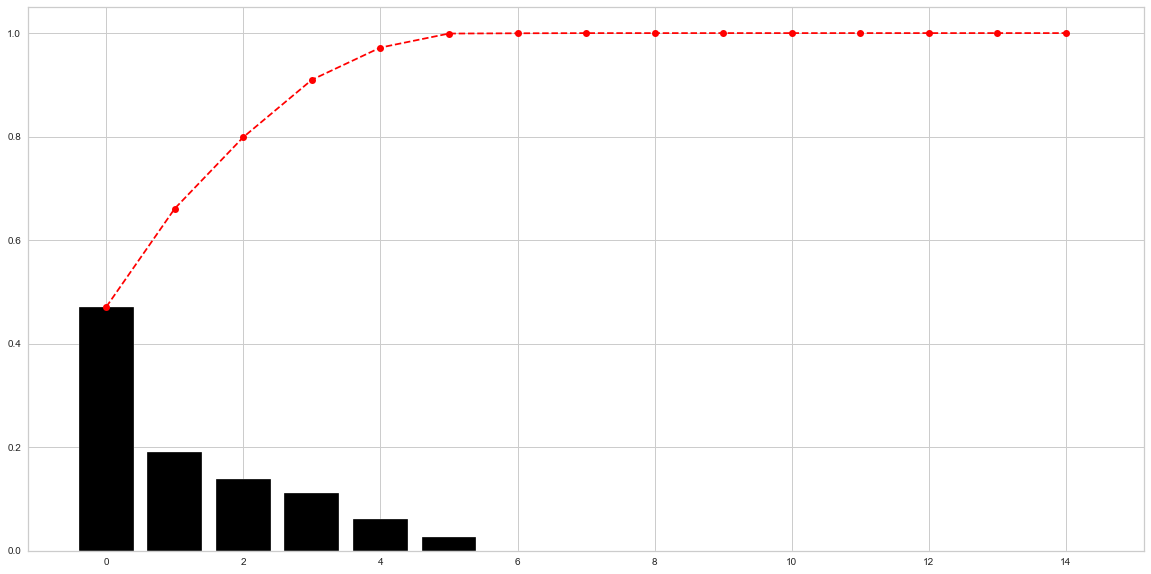

In [323]:
features = range(pca.n_components)
plt.figure(figsize=(20,10))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.plot (features, pca.explained_variance_ratio_.cumsum(), color='red', linestyle='--', marker='o');

In [297]:
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df06)

#sns.scatterplot( x= principalComponents[ :, 0], y = principalComponents[ :, 1]);
#Isso se deve à natureza linear do PCA

## Uniform Manifold Approximation and Projection (UMAP)

In [298]:
reducer = umap.UMAP(n_components = 5, n_neighbors = 1000 , min_dist=0.0, random_state=42)
embedding_umap = reducer.fit_transform(df06)

# plot UMAP
#sns.scatterplot( x= embedding_umap[ :, 0], y = embedding_umap[ :, 1]);

# Feature Selection

In [238]:
#df07 = df_leafs.copy()

# Hyperparameter Fine-Tunning

In [252]:
df08 = pd.DataFrame(df06)

# Model Training

In [177]:
df09 = pd.DataFrame(df05).copy()

In [178]:
clusters = list(range(2, 11))

## K-Means clustering (K-Means)

In [179]:
silhouette_list = []
davies_list = []
calinski_list = []

for k in clusters:
    # model definition
    kmeans_model = cl.KMeans (n_clusters = k)

    # model training
    kmeans_model.fit(df09.values)

    # model predict
    labels_kmeans = kmeans_model.predict(df09.values)

    # model performance
    sil = mt.silhouette_score(df09, labels_kmeans)
    dav = mt.davies_bouldin_score(df09, labels_kmeans)
    cal = mt.calinski_harabasz_score(df09, labels_kmeans)
    silhouette_list.append(sil)
    davies_list.append(dav)
    calinski_list.append (cal)
    
    # metrics
    print ("For n_clusters = {0}: \nSS Score = {1}, DB Score = {2}, CH Score = {3} ".format(k, sil, dav, cal))
    print(100 * "-")

For n_clusters = 2: 
SS Score = 0.7696995324941713, DB Score = 0.5592317998486096, CH Score = 10897.516676182942 
----------------------------------------------------------------------------------------------------
For n_clusters = 3: 
SS Score = 0.6472857362932928, DB Score = 0.6022177117042795, CH Score = 11718.70376080834 
----------------------------------------------------------------------------------------------------
For n_clusters = 4: 
SS Score = 0.5981860970685329, DB Score = 0.584329826137542, CH Score = 12824.906106547396 
----------------------------------------------------------------------------------------------------
For n_clusters = 5: 
SS Score = 0.4759833965715952, DB Score = 0.6563779732632109, CH Score = 12923.89546409073 
----------------------------------------------------------------------------------------------------
For n_clusters = 6: 
SS Score = 0.5092699696609427, DB Score = 0.6237831023486603, CH Score = 13416.769312030001 
-----------------------------

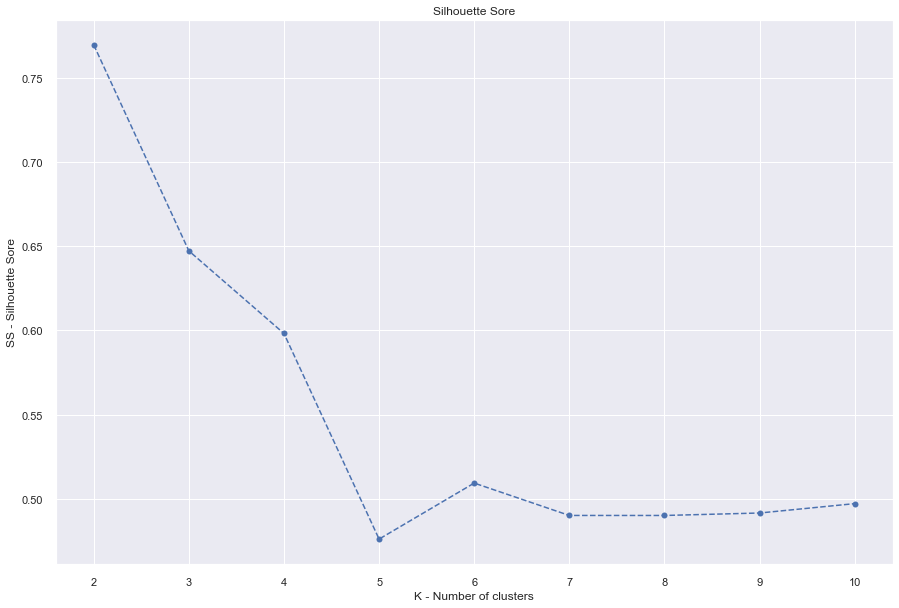

In [192]:
plt.figure( figsize=(15, 10 ))
plt.plot( clusters, silhouette_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K - Number of clusters')
plt.ylabel( 'SS - Silhouette Sore')
plt.title( 'Silhouette Sore');

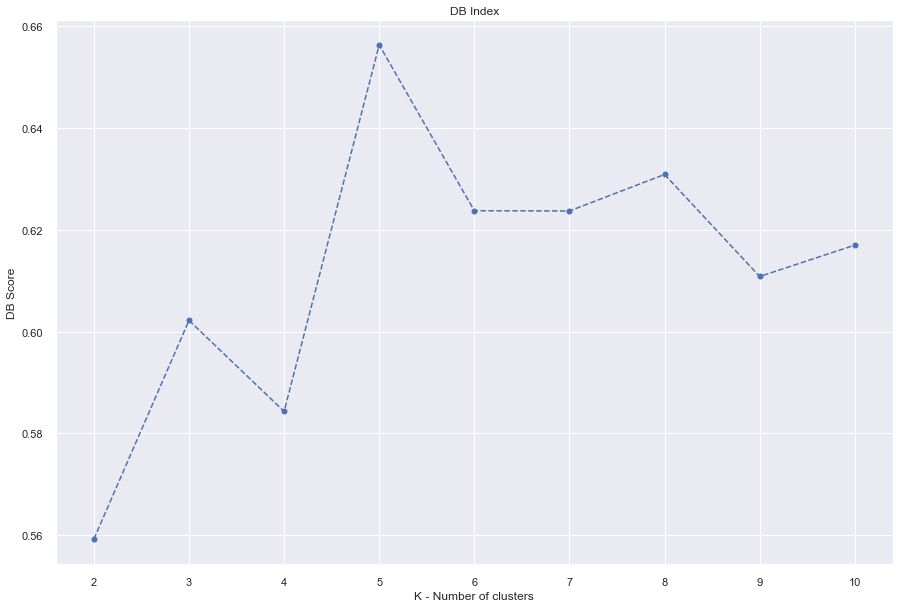

In [193]:
plt.figure( figsize=(15, 10 ))
plt.plot( clusters, davies_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K - Number of clusters')
plt.ylabel( 'DB Score')
plt.title( 'DB Index');

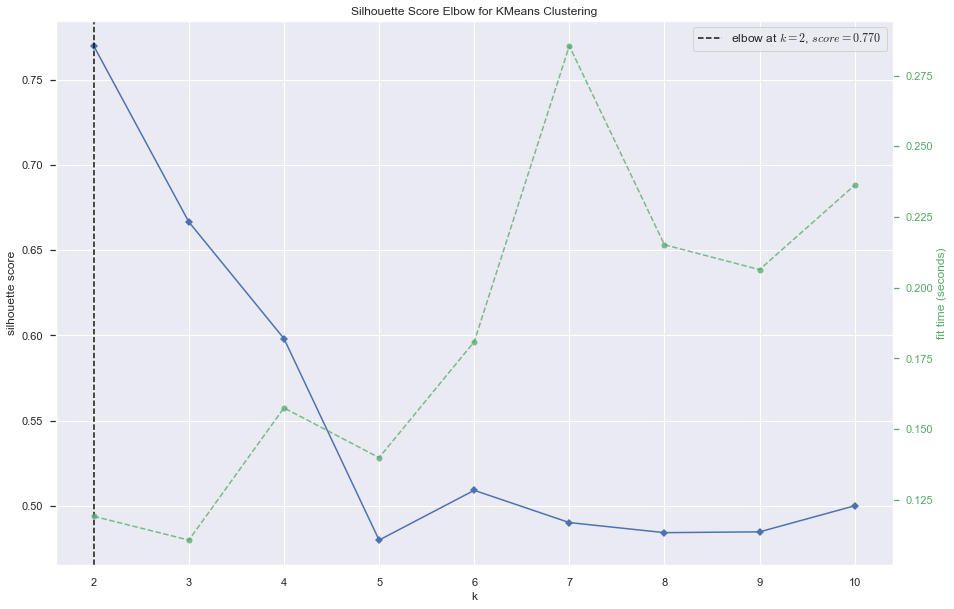

In [194]:
distortion_visualizer = KElbowVisualizer(kmeans_model, k=clusters, metric ='silhouette')
distortion_visualizer.fit(df09.values)       
distortion_visualizer.show();

## Gaussian Mixture Model (GMM)

In [259]:
silhouette_list = []
davies_list = []
calinski_score = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components = k)

    # model training
    gmm_model.fit (df09.values)

    # model prediction
    labels_gmm = gmm_model.predict (df09.values)

    # model performance
    sil = mt.silhouette_score(df09.values, labels_gmm)
    dav = mt.davies_bouldin_score(df09.values, labels_gmm)
    silhouette_list.append(sil)
    davies_list.append(dav)
    
    # silhouette score
    print ("\nFor n_clusters = {0}: \nsilhouette score = {1}, DB Index = {2}".format(k, sil, dav))


For n_clusters = 2: 
silhouette score = 0.2906841812439358, DB Index = 1.3729258262983774

For n_clusters = 3: 
silhouette score = 0.2400989937108326, DB Index = 2.032992637505948

For n_clusters = 4: 
silhouette score = 0.05060741507183273, DB Index = 2.3567833582423203

For n_clusters = 5: 
silhouette score = 0.021244555734798116, DB Index = 2.090895883486513

For n_clusters = 6: 
silhouette score = 0.01747789151723708, DB Index = 2.5927427997052885

For n_clusters = 7: 
silhouette score = -0.07201709897107854, DB Index = 1.8509431388242255

For n_clusters = 8: 
silhouette score = -0.05802351820473386, DB Index = 2.3651423274150183

For n_clusters = 9: 
silhouette score = -0.03298494242938023, DB Index = 3.2342340642842196

For n_clusters = 10: 
silhouette score = -0.02125423564762034, DB Index = 2.6120205930308127


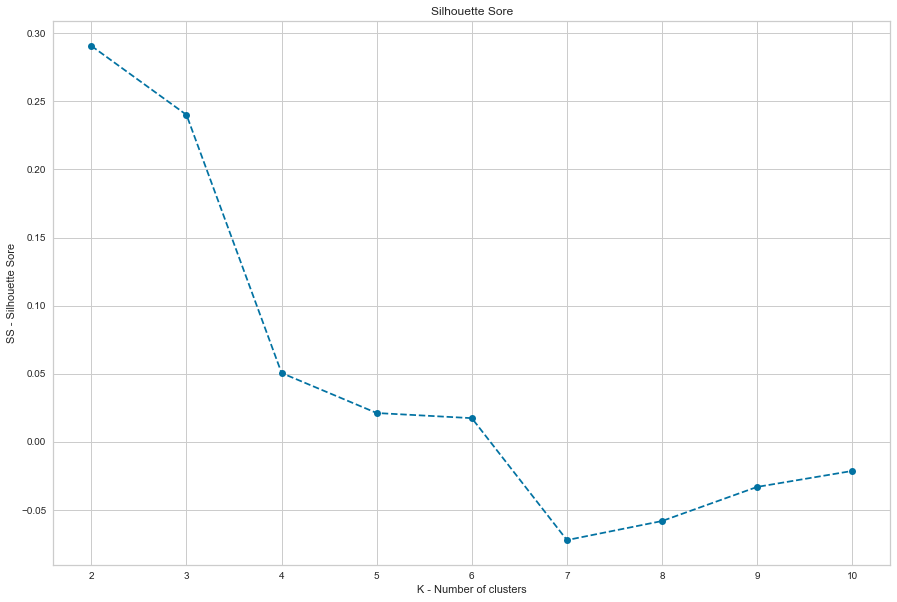

In [260]:
plt.figure( figsize=(15, 10 ))
plt.plot( clusters, silhouette_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K - Number of clusters')
plt.ylabel( 'SS - Silhouette Sore')
plt.title( 'Silhouette Sore');

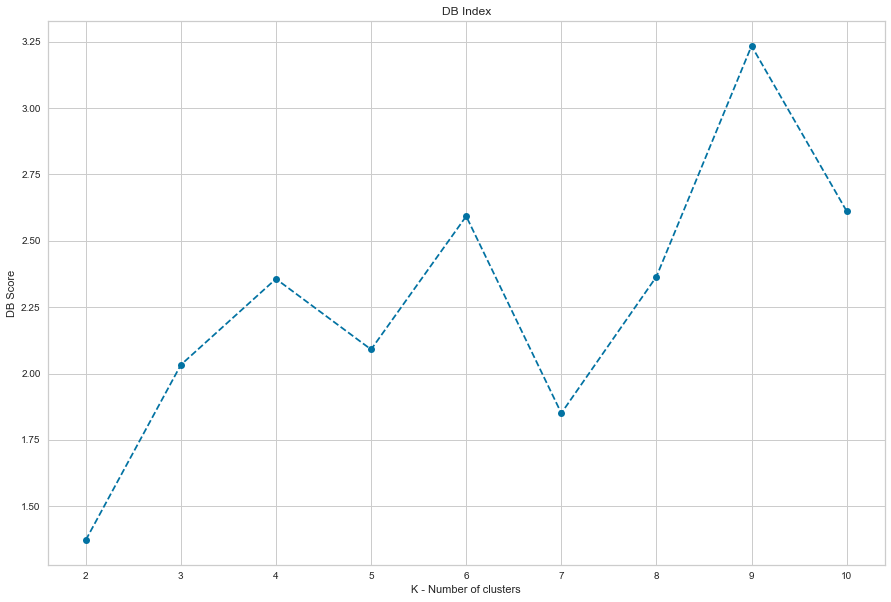

In [261]:
plt.figure( figsize=(15, 10 ))
plt.plot( clusters, davies_list, linestyle = '--', marker = 'o', color = 'b');
plt.xlabel('K - Number of clusters')
plt.ylabel( 'DB Score')
plt.title( 'DB Index');

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

In [184]:
neigh = NearestNeighbors()
nbrs = neigh.fit(df09)
distances, indices = nbrs.kneighbors(df09)

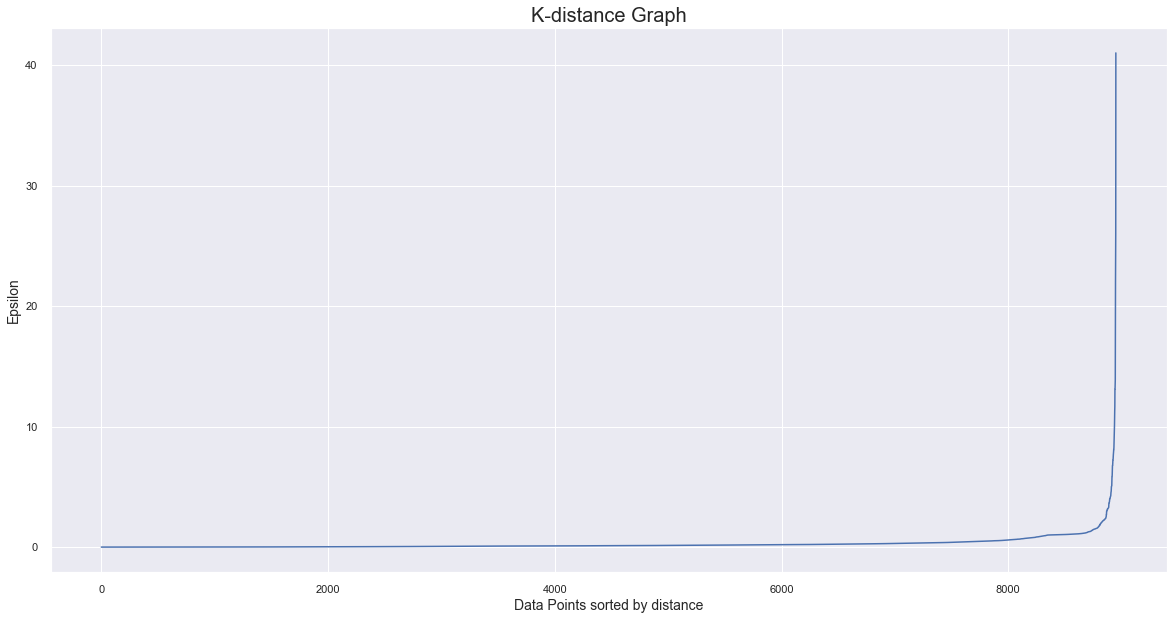

In [185]:
# Plotting K-distance Graph
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

In [189]:
eps = 4
min_samples = 50

# model definition
dbscan_model = cl.DBSCAN (eps=eps, min_samples=min_samples)

# model training & predict
labels = dbscan_model.fit_predict (df09)

sil = mt.silhouette_score ( df09.values, labels,  metric =  'euclidean')
print('Silhouette Score: {}'.format(sil))
print('Number of Clusters: {}'. format(len( unique(labels))))
print(unique(labels))

Silhouette Score: 0.7247692523966677
Number of Clusters: 2
[-1  0]


## hierarchy

In [190]:
import scipy.cluster.hierarchy as shc

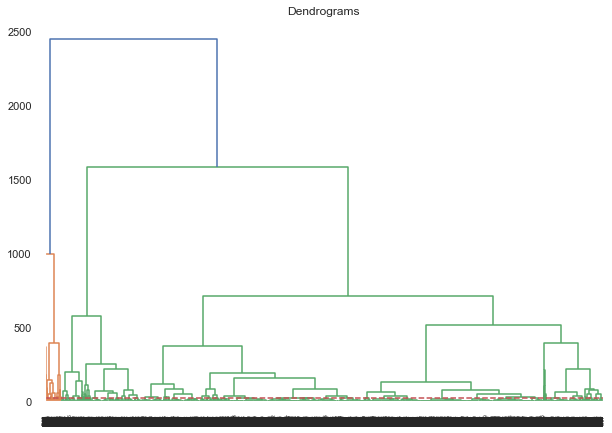

In [191]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df09, method='ward'))
plt.axhline(y=20, color='r', linestyle='--')

In [265]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df06)

array([3, 2, 0, ..., 3, 2, 1], dtype=int64)

# Model Training

In [198]:
k = 4

# model definition
kmeans_model = cl.KMeans (n_clusters = k)
# model training
kmeans_model.fit(df09.values)
# model predict
labels_KMeans = kmeans_model.predict(df09.values)

In [199]:
## SS (Silhoutte Score) 
print('SS - Silhouette Score KMeans: {}'.format(mt.silhouette_score(df09, labels_KMeans, metric='euclidean')))

SS - Silhouette Score KMeans: 0.601910283664987


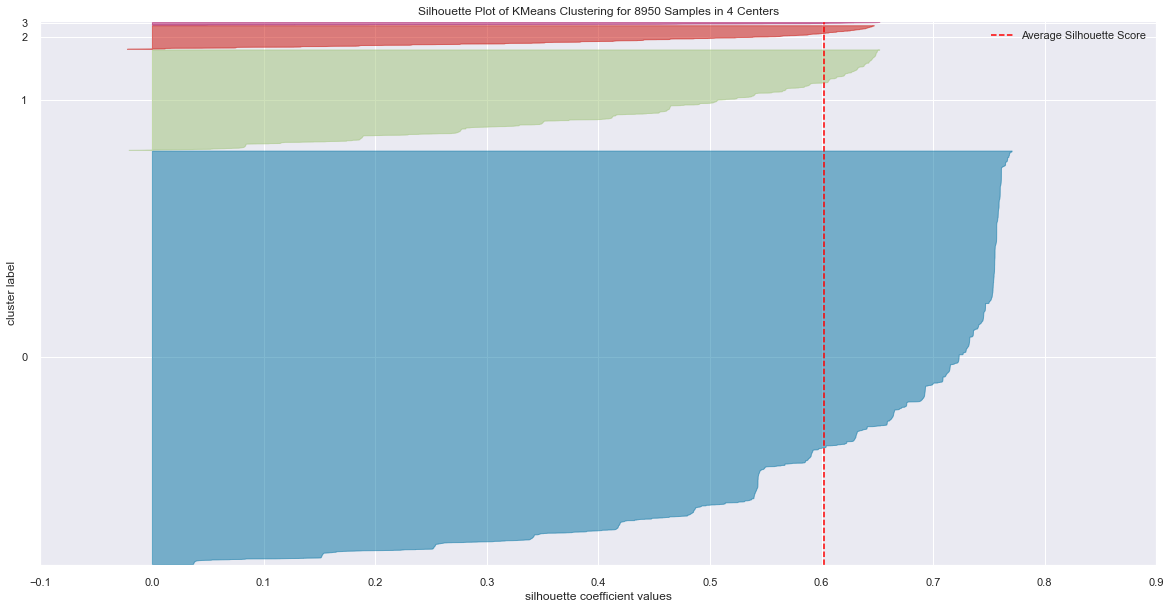

In [200]:
visualizer = SilhouetteVisualizer(kmeans_model, colors='yellowbrick')
plt.figure(figsize=(20,10))
visualizer.fit(df09.values)
visualizer.show();